## Database setup and statistical analyis

disaster_db tables
- 0         geography_columns
- 1          geometry_columns
- 2           spatial_ref_sys
- 3   nri_shape_census_tracts
- 4       NOAA_STORM_EPISODES
- 5         NOAA_STORM_EVENTS
- 6         census_resilience
- 7  POISSON_FREQUENCY_PARAMS


<div class="alert alert-block alert-warning"><b>Example:</b>NOTE: Tables 0:2 are required for querying spacial data and converting between coordinate systems. Do not modify or remove. Origin, FEMA_NRI, see readme for more information.</div>





In [1]:
# import libraries
# NOTE: global_vars should be edited to include local paths and credentials before use.
import ignore.global_vars as gv
import db_tools as dbt
import pandas as pd
import sqlalchemy
import sys
from IPython.display import display, HTML
from scipy import stats
from scipy.stats import poisson, nbinom
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from matplotlib.colors import LinearSegmentedColormap
import plotly.express as px
import plotly.graph_objects as go
import shapely as wkt
import os

In [2]:
# open connection and get table names
table_names = dbt.query("SELECT table_name FROM information_schema.tables WHERE table_schema='public'")
print(table_names)


Created SQLAlchemy engine for disaster_db
                 table_name
0         geography_columns
1          geometry_columns
2           spatial_ref_sys
3  POISSON_FREQUENCY_PARAMS
4     disaster_risk_spatial
5   nri_shape_census_tracts
6       NOAA_STORM_EPISODES
7         NOAA_STORM_EVENTS
8         census_resilience


### Fitting Poisson distributions to historical disaster event counts ###


Poission process was chosen for disaster occurence due to:
- Right-tail skewed distribution
- Data is random
- Data is discrete
- Data is random
- Data is time series 



$$P(N_{i,t} = k) = \frac{\lambda_i^k e^{-\lambda_i}}{k!}$$

Where:  
$N_{i,t}$ = number of disaster episodes in county $i$ during year $t$  
$k$ = observed count (0, 1, 2, 3, ...)  
$\lambda_i$ = county-specific rate parameter (average annual episodes)  
$e$ = Euler's number (≈ 2.718)  
$k!$ = factorial of $k$  

$$N_{i,t} \sim \text{P}(\lambda_i)$$

Where:  
$N_{i,t}$ = number of disaster episodes in county $i$ during year $t$  
$\lambda_i$ = county-specific average annual episode rate  


---


Events per tract per year ~ Poisson(λ)
where λ = average annual event rate


Step 1: Event Frequency ~ Poisson(λ)     [NOAA data]
Step 2: Event Severity ~ Distribution    [Census resilience data]

Total Annual Loss = Σ(i=1 to N) Yi

Where:
- N ~ Poisson(λ)           [Number of events from NOAA]
- Yi ~ Severity Distribution [Potential impact per event from Census data as vunerability]
- λ = NOAA historical event frequency
- Yi = f(population, vulnerability, demographics)


Poisson Model Framework:
- N ~ Poisson(λ) where N = annual episodes per county
- λ = county-specific average annual episode rate
- Goal: Estimate λ for each county from historical data

Poisson Fitting Steps:
1. Calculate λ for each county: λ = mean(annual episodes)
2. Test goodness of fit (chi-square or Kolmogorov-Smirnov)
3. Check for overdispersion (variance >> mean)
4. Consider Negative Binomial if overdispersed


\begin{align}
N_i &\sim \text{Poisson}(\lambda_i) \quad \text{[Frequency from NOAA]} \\
Y_{i,j} &\sim F_i(\theta_i) \quad \text{[Severity from Census]} \\
S_i &= \sum_{j=1}^{N_i} Y_{i,j} \quad \text{[Total Risk]}
\end{align}

In [3]:
geography_columns = dbt.query("SELECT * FROM geography_columns")
geography_columns.head()

Created SQLAlchemy engine for disaster_db


,f_table_catalog,f_table_schema,f_table_name,f_geography_column,coord_dimension,srid,type


In [4]:
# Load the NOAA data into a DataFrame for analysis
df_noaa = dbt.query("SELECT * FROM \"NOAA_STORM_EPISODES\" ORDER BY county_fips, year")


Created SQLAlchemy engine for disaster_db


In [5]:
# Basic data exploration of NOAA episodes
print("=== NOAA EPISODES DATA EXPLORATION ===")
print(f"DataFrame shape: {df_noaa.shape}")
print(f"Columns: {list(df_noaa.columns)}")
print(f"Data types:")
print(df_noaa.dtypes)

print(f"\n=== BASIC STATISTICS ===")
print(f"Year range: {df_noaa['year'].min()} - {df_noaa['year'].max()}")
print(f"Unique counties: {df_noaa['county_fips'].nunique()}")
print(f"Total county-year records: {len(df_noaa)}")
print(f"Event count statistics:")
print(df_noaa['event_count'].describe())

=== NOAA EPISODES DATA EXPLORATION ===
DataFrame shape: (98488, 3)
Columns: ['county_fips', 'year', 'event_count']
Data types:
county_fips    object
year            int64
event_count     int64
dtype: object

=== BASIC STATISTICS ===
Year range: 1999 - 2024
Unique counties: 3788
Total county-year records: 98488
Event count statistics:
count    98488.000000
mean         0.182570
std          0.602675
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         21.000000
Name: event_count, dtype: float64


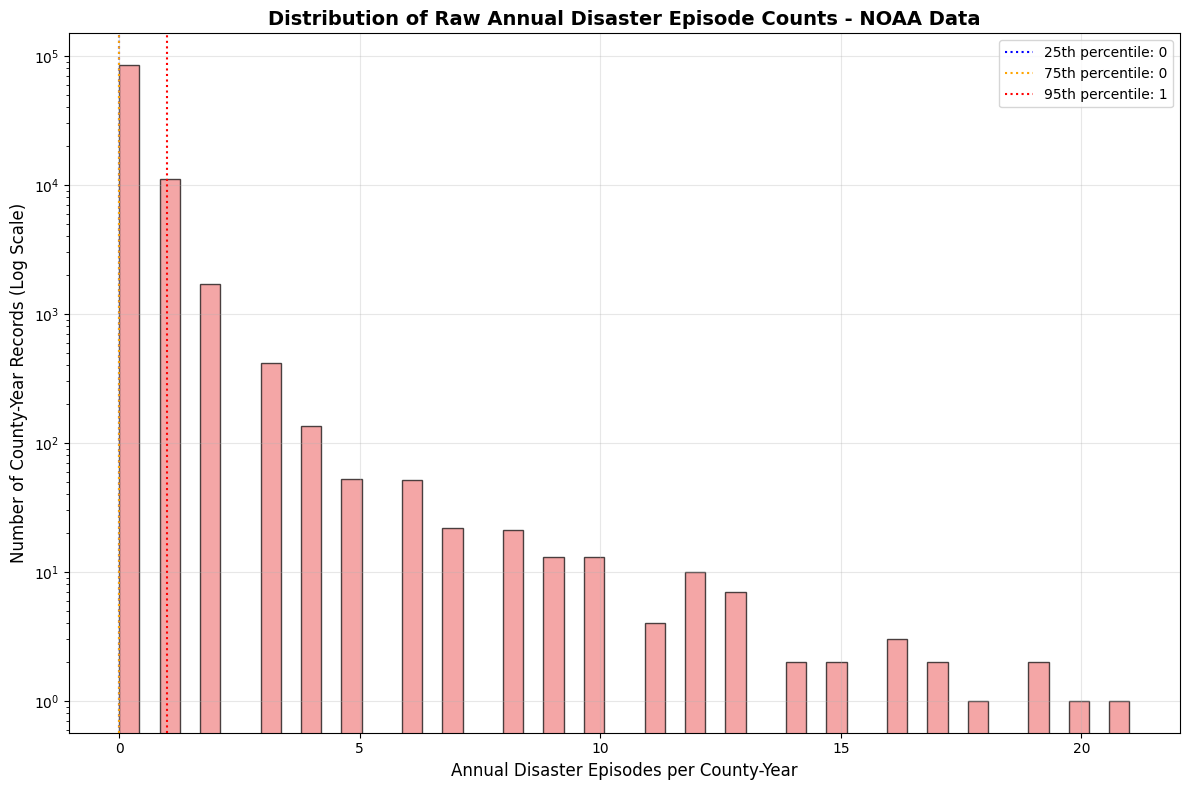

In [6]:
# Create histogram of raw event counts with log scale for distribution analysis
plt.figure(figsize=(12, 8))
plt.hist(df_noaa['event_count'], bins=50, alpha=0.7, edgecolor='black', color='lightcoral')
plt.xlabel('Annual Disaster Episodes per County-Year', fontsize=12)
plt.ylabel('Number of County-Year Records (Log Scale)', fontsize=12)
plt.title('Distribution of Raw Annual Disaster Episode Counts - NOAA Data', fontsize=14, fontweight='bold')
plt.yscale('log')

# Add percentiles to help interpretation with log scale
raw_counts = df_noaa['event_count']
p25_raw = raw_counts.quantile(0.25)
p75_raw = raw_counts.quantile(0.75)
p95_raw = raw_counts.quantile(0.95)

plt.axvline(p25_raw, color='blue', linestyle=':', label=f'25th percentile: {p25_raw:.0f}')
plt.axvline(p75_raw, color='orange', linestyle=':', label=f'75th percentile: {p75_raw:.0f}')
plt.axvline(p95_raw, color='red', linestyle=':', label=f'95th percentile: {p95_raw:.0f}')

plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [7]:
# Calculate lambda for each county

county_lambdas = df_noaa.groupby('county_fips').agg({
    'event_count': ['mean', 'var', 'std', 'count', 'sum'],
    'year': ['min', 'max']
}).round(4)

# Flatten column names
county_lambdas.columns = ['_'.join(col).strip() for col in county_lambdas.columns]
county_lambdas = county_lambdas.reset_index()

# Rename for clarity
county_lambdas.rename(columns={
    'event_count_mean': 'lambda_hat',
    'event_count_var': 'variance', 
    'event_count_std': 'std_dev',
    'event_count_count': 'years_observed',
    'event_count_sum': 'total_events',
    'year_min': 'first_year',
    'year_max': 'last_year'
}, inplace=True)

# Calculate overdispersion ratio (variance/mean)
county_lambdas['overdispersion_ratio'] = np.where(
    county_lambdas['lambda_hat'] > 0,
    county_lambdas['variance'] / county_lambdas['lambda_hat'],
    np.nan
)

print(f"Lambda estimates calculated for {len(county_lambdas)} counties")
print("\nCounty-level Poisson parameters (sample):")
display(county_lambdas.head(10))

Lambda estimates calculated for 3788 counties

County-level Poisson parameters (sample):


,county_fips,lambda_hat,variance,std_dev,years_observed,total_events,first_year,last_year,overdispersion_ratio
0,01001,0.5000,0.4200,0.6481,26,13,1999,2024,0.840000
1,01002,0.1538,0.1354,0.3679,26,4,1999,2024,0.880364
2,01003,1.1538,1.1754,1.0842,26,30,1999,2024,1.018721
3,01004,0.0769,0.0738,0.2717,26,2,1999,2024,0.959688
4,01005,0.2308,0.1846,0.4297,26,6,1999,2024,0.799827
5,01006,0.4231,0.6538,0.8086,26,11,1999,2024,1.545261
6,01007,0.3846,0.4062,0.6373,26,10,1999,2024,1.056162
7,01008,0.1538,0.1354,0.3679,26,4,1999,2024,0.880364
8,01009,0.4231,0.3338,0.5778,26,11,1999,2024,0.788939
9,01010,0.0385,0.0385,0.1961,26,1,1999,2024,1.000000


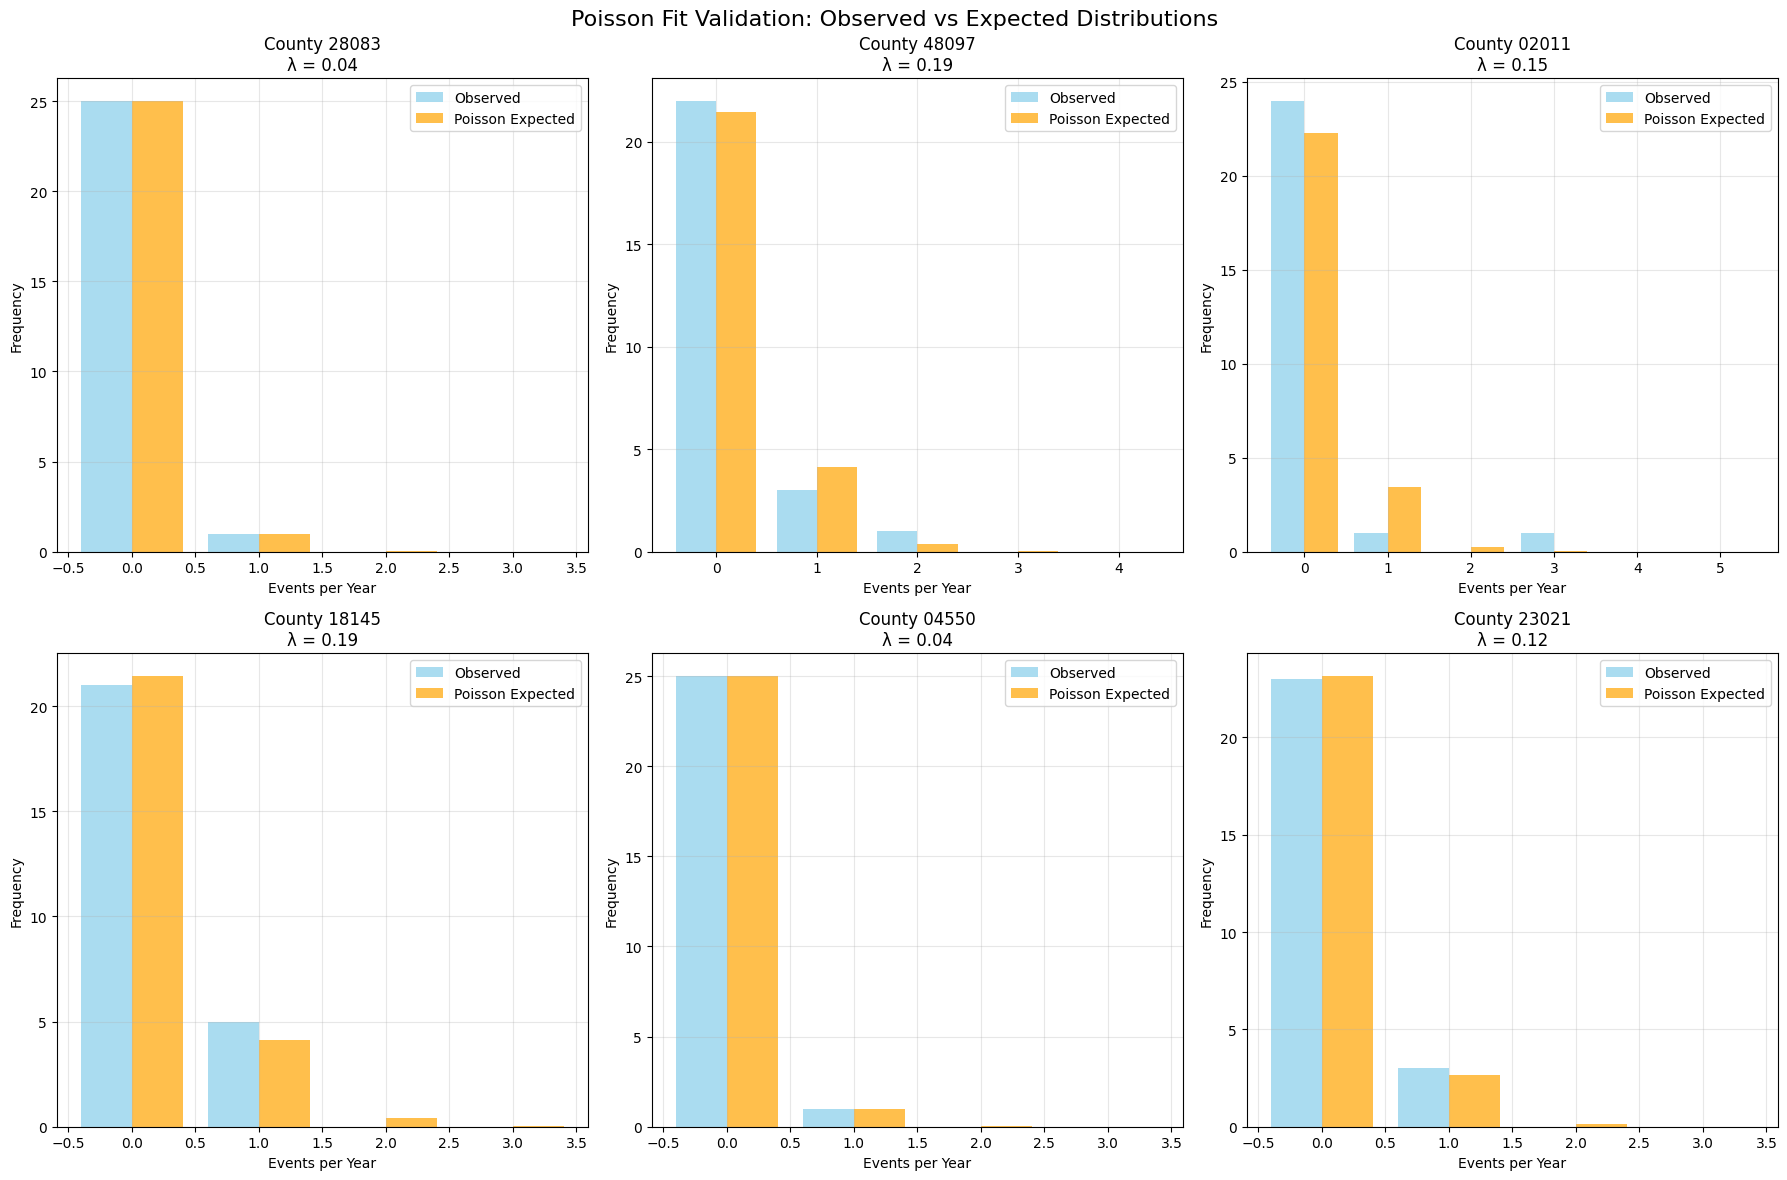

In [8]:
# Select a few representative counties for detailed analysis
sample_counties = county_lambdas.sample(6, random_state=36)  # reproducible sample

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for i, (_, county) in enumerate(sample_counties.iterrows()):
    county_fips = county['county_fips']
    lambda_est = county['lambda_hat']

    county_data = df_noaa[df_noaa['county_fips'] == county_fips]['event_count']
    max_events = int(county_data.max()) + 2
    x_vals = range(0, max_events + 1)
    theoretical_probs = [poisson.pmf(k, lambda_est) for k in x_vals]
    theoretical_counts = [p * len(county_data) for p in theoretical_probs]
    actual_counts = [sum(county_data == k) for k in x_vals]
    
    # Plot
    axes[i].bar([x - 0.2 for x in x_vals], actual_counts, width=0.4, 
                label='Observed', alpha=0.7, color='skyblue')
    axes[i].bar([x + 0.2 for x in x_vals], theoretical_counts, width=0.4, 
                label='Poisson Expected', alpha=0.7, color='orange')
    
    axes[i].set_title(f'County {county_fips}\nλ = {lambda_est:.2f}')
    axes[i].set_xlabel('Events per Year')
    axes[i].set_ylabel('Frequency')
    axes[i].legend()
    axes[i].grid(alpha=0.3)

plt.suptitle('Poisson Fit Validation: Observed vs Expected Distributions', fontsize=16)
plt.tight_layout()
plt.show()

In [ ]:
# make a dataframe of the poisson risk parameters
poisson_risk_params = county_lambdas[['county_fips', 'lambda_hat', 'years_observed', 'total_events']].copy()

# Add confidence intervals for lambda estimates (assuming Poisson MLE)
# For Poisson MLE, CI is approximately: λ ± 1.96 * sqrt(λ/n)
poisson_risk_params['lambda_se'] = np.sqrt(poisson_risk_params['lambda_hat'] / poisson_risk_params['years_observed'])
poisson_risk_params['lambda_ci_lower'] = poisson_risk_params['lambda_hat'] - 1.96 * poisson_risk_params['lambda_se']
poisson_risk_params['lambda_ci_upper'] = poisson_risk_params['lambda_hat'] + 1.96 * poisson_risk_params['lambda_se']

# Ensure lower bound is non-negative
poisson_risk_params['lambda_ci_lower'] = np.maximum(0, poisson_risk_params['lambda_ci_lower'])

print("Poisson Risk Parameters (sample):")
display(poisson_risk_params.head(10))

Poisson Risk Parameters (sample):


,county_fips,lambda_hat,years_observed,total_events,lambda_se,lambda_ci_lower,lambda_ci_upper
0,01001,0.5000,26,13,0.138675,0.228197,0.771803
1,01002,0.1538,26,4,0.076912,0.003053,0.304547
2,01003,1.1538,26,30,0.210658,0.740910,1.566690
3,01004,0.0769,26,2,0.054385,0.000000,0.183494
4,01005,0.2308,26,6,0.094217,0.046134,0.415466
5,01006,0.4231,26,11,0.127566,0.173071,0.673129
6,01007,0.3846,26,10,0.121624,0.146218,0.622982
7,01008,0.1538,26,4,0.076912,0.003053,0.304547
8,01009,0.4231,26,11,0.127566,0.173071,0.673129
9,01010,0.0385,26,1,0.038481,0.000000,0.113922


In [10]:
# Risk classification based on lambda estimates
def classify_risk_level(lambda_val):
    if lambda_val < 0.5:
        return 'Very Low'
    elif lambda_val < 2:
        return 'Low' 
    elif lambda_val < 5:
        return 'Moderate'
    elif lambda_val < 10:
        return 'High'
    else:
        return 'Very High'

poisson_risk_params['risk_category'] = poisson_risk_params['lambda_hat'].apply(classify_risk_level)

print("Risk category distribution:")
print(poisson_risk_params['risk_category'].value_counts().sort_index())

Risk category distribution:
risk_category
High           2
Low          235
Moderate      16
Very Low    3535
Name: count, dtype: int64


In [11]:
# Create state-level risk mapping without geographic boundaries
# Extract state FIPS from county FIPS (first 2 digits)
poisson_risk_params['state_fips'] = poisson_risk_params['county_fips'].str[:2]

# State FIPS to state name mapping (major states)
state_fips_map = {
    '01': 'Alabama', '02': 'Alaska', '04': 'Arizona', '05': 'Arkansas', '06': 'California',
    '08': 'Colorado', '09': 'Connecticut', '10': 'Delaware', '11': 'DC', '12': 'Florida',
    '13': 'Georgia', '15': 'Hawaii', '16': 'Idaho', '17': 'Illinois', '18': 'Indiana',
    '19': 'Iowa', '20': 'Kansas', '21': 'Kentucky', '22': 'Louisiana', '23': 'Maine',
    '24': 'Maryland', '25': 'Massachusetts', '26': 'Michigan', '27': 'Minnesota', '28': 'Mississippi',
    '29': 'Missouri', '30': 'Montana', '31': 'Nebraska', '32': 'Nevada', '33': 'New Hampshire',
    '34': 'New Jersey', '35': 'New Mexico', '36': 'New York', '37': 'North Carolina', '38': 'North Dakota',
    '39': 'Ohio', '40': 'Oklahoma', '41': 'Oregon', '42': 'Pennsylvania', '44': 'Rhode Island',
    '45': 'South Carolina', '46': 'South Dakota', '47': 'Tennessee', '48': 'Texas', '49': 'Utah',
    '50': 'Vermont', '51': 'Virginia', '53': 'Washington', '54': 'West Virginia', '55': 'Wisconsin', '56': 'Wyoming'
}

poisson_risk_params['state_name'] = poisson_risk_params['state_fips'].map(state_fips_map)

In [12]:
# Create spatial database table for QGIS access
import geopandas as gpd
from shapely import wkt
import os

print("🚀 Creating spatial database table for QGIS access...")

# Step 1: Load and prepare the geographic data
print("📍 Loading NRI shapefile data...")
nri_gdf = dbt.query("""
    SELECT 
        "STCOFIPS" as county_fips,
        ST_AsText("geometry") as geometry_wkt,
        "TRACTFIPS" as tract_geoid,
        "POPULATION",
        "RISK_SCORE"
    FROM nri_shape_census_tracts
    WHERE "geometry" IS NOT NULL
    AND "STCOFIPS" IS NOT NULL
""")

if len(nri_gdf) > 0:
    print(f"✅ Loaded {len(nri_gdf)} census tracts")
    
    # Convert WKT to geometries for processing
    nri_gdf['geometry'] = nri_gdf['geometry_wkt'].apply(wkt.loads)
    nri_gdf = gpd.GeoDataFrame(nri_gdf, geometry='geometry')
    
    # Aggregate to county level
    print("🗺️ Aggregating to county boundaries...")
    county_boundaries = nri_gdf.dissolve(by='county_fips').reset_index()
    county_boundaries = county_boundaries[['county_fips', 'geometry']]
    
    # Merge with lambda data
    print("📊 Merging with Poisson lambda estimates...")
    lambda_map_data = county_boundaries.merge(
        poisson_risk_params[['county_fips', 'lambda_hat', 'risk_category', 'state_name', 
                           'total_events', 'years_observed', 'lambda_ci_lower', 'lambda_ci_upper']], 
        on='county_fips', 
        how='left'
    )
    
    # Clean data
    lambda_map_clean = lambda_map_data.dropna(subset=['lambda_hat'])
    
    # Add useful columns for QGIS
    lambda_map_clean['lambda_rounded'] = lambda_map_clean['lambda_hat'].round(3)
    lambda_map_clean['risk_numeric'] = lambda_map_clean['risk_category'].map({
        'Very Low': 1, 'Low': 2, 'Moderate': 3, 'High': 4, 'Very High': 5
    })
    
    print(f"✅ Prepared {len(lambda_map_clean)} counties with complete data")
    
    # Convert geometry back to WKT for database storage
    lambda_map_clean['geometry_wkt'] = lambda_map_clean['geometry'].apply(lambda x: x.wkt)
    
    # Prepare data for database (drop geometry column, keep WKT)
    db_data = lambda_map_clean.drop('geometry', axis=1)
    
    # Save to database
    print("💾 Saving spatial data to database...")
    dbt.load_data(db_data, "disaster_risk_spatial", if_exists="replace")
    
    # Create proper spatial table with PostGIS geometry
    print("🗺️ Creating PostGIS spatial table...")
    spatial_table_sql = """
    DROP TABLE IF EXISTS disaster_risk_counties_spatial;
    
    CREATE TABLE disaster_risk_counties_spatial AS
    SELECT 
        county_fips,
        lambda_hat,
        lambda_rounded,
        risk_category,
        risk_numeric,
        state_name,
        total_events,
        years_observed,
        lambda_ci_lower,
        lambda_ci_upper,
        ST_GeomFromText(geometry_wkt, 4326) as geometry
    FROM disaster_risk_spatial;
    
    -- Add spatial index for performance
    CREATE INDEX idx_disaster_risk_counties_spatial_geom 
    ON disaster_risk_counties_spatial USING GIST (geometry);
    
    -- Add primary key
    ALTER TABLE disaster_risk_counties_spatial 
    ADD CONSTRAINT pk_disaster_risk_counties_spatial PRIMARY KEY (county_fips);
    """
    
    dbt.execute_sql(spatial_table_sql)
    
    print("✅ Spatial database table created: disaster_risk_counties_spatial")
    print(f"   📍 {len(lambda_map_clean)} counties with geometry")
    print(f"   🗂️ Columns: county_fips, lambda_hat, risk_category, state_name, geometry, etc.")
    print(f"   🔍 Spatial index created for fast mapping")
    
else:
    print("❌ No geographic data available")

🚀 Creating spatial database table for QGIS access...
📍 Loading NRI shapefile data...
Created SQLAlchemy engine for disaster_db
✅ Loaded 85154 census tracts
🗺️ Aggregating to county boundaries...
📊 Merging with Poisson lambda estimates...
✅ Prepared 2658 counties with complete data


c:\Users\alben\AppData\Local\Programs\Python\Python313\Lib\site-packages\geopandas\geodataframe.py:1968: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\alben\AppData\Local\Programs\Python\Python313\Lib\site-packages\geopandas\geodataframe.py:1968: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\alben\AppData\Local\Programs\Python\Python313\Lib\site-packages\geopandas\geodataframe.py:1968: SettingWithCopyWarning: 
A value is tryin

💾 Saving spatial data to database...
Created SQLAlchemy engine for disaster_db
Data loaded successfully into disaster_risk_spatial
🗺️ Creating PostGIS spatial table...
Connection established
SQL executed successfully
✅ Spatial database table created: disaster_risk_counties_spatial
   📍 2658 counties with geometry
   🗂️ Columns: county_fips, lambda_hat, risk_category, state_name, geometry, etc.
   🔍 Spatial index created for fast mapping


## BREAK, delete this cell

next steps
Severity modeling using census resilience data
Compound model integration (frequency × severity)
Risk scenario simulation
Geographic risk mapping

In [13]:
# Calculate lambda (average annual event rate) for each county
county_lambdas = df_noaa.groupby('county_fips').agg({
    'event_count': ['mean', 'var', 'std', 'count', 'sum'],
    'year': ['min', 'max']
}).round(4)

# Flatten column names
county_lambdas.columns = ['_'.join(col).strip() for col in county_lambdas.columns]
county_lambdas = county_lambdas.reset_index()

# Rename for clarity
county_lambdas.rename(columns={
    'event_count_mean': 'lambda_hat',
    'event_count_var': 'variance', 
    'event_count_std': 'std_dev',
    'event_count_count': 'years_observed',
    'event_count_sum': 'total_events',
    'year_min': 'first_year',
    'year_max': 'last_year'
}, inplace=True)

# Calculate overdispersion ratio (variance/mean)
county_lambdas['overdispersion_ratio'] = county_lambdas['variance'] / county_lambdas['lambda_hat']

print("County-level Poisson parameters:")
display(county_lambdas.head(10))

County-level Poisson parameters:


,county_fips,lambda_hat,variance,std_dev,years_observed,total_events,first_year,last_year,overdispersion_ratio
0,01001,0.5000,0.4200,0.6481,26,13,1999,2024,0.840000
1,01002,0.1538,0.1354,0.3679,26,4,1999,2024,0.880364
2,01003,1.1538,1.1754,1.0842,26,30,1999,2024,1.018721
3,01004,0.0769,0.0738,0.2717,26,2,1999,2024,0.959688
4,01005,0.2308,0.1846,0.4297,26,6,1999,2024,0.799827
5,01006,0.4231,0.6538,0.8086,26,11,1999,2024,1.545261
6,01007,0.3846,0.4062,0.6373,26,10,1999,2024,1.056162
7,01008,0.1538,0.1354,0.3679,26,4,1999,2024,0.880364
8,01009,0.4231,0.3338,0.5778,26,11,1999,2024,0.788939
9,01010,0.0385,0.0385,0.1961,26,1,1999,2024,1.000000


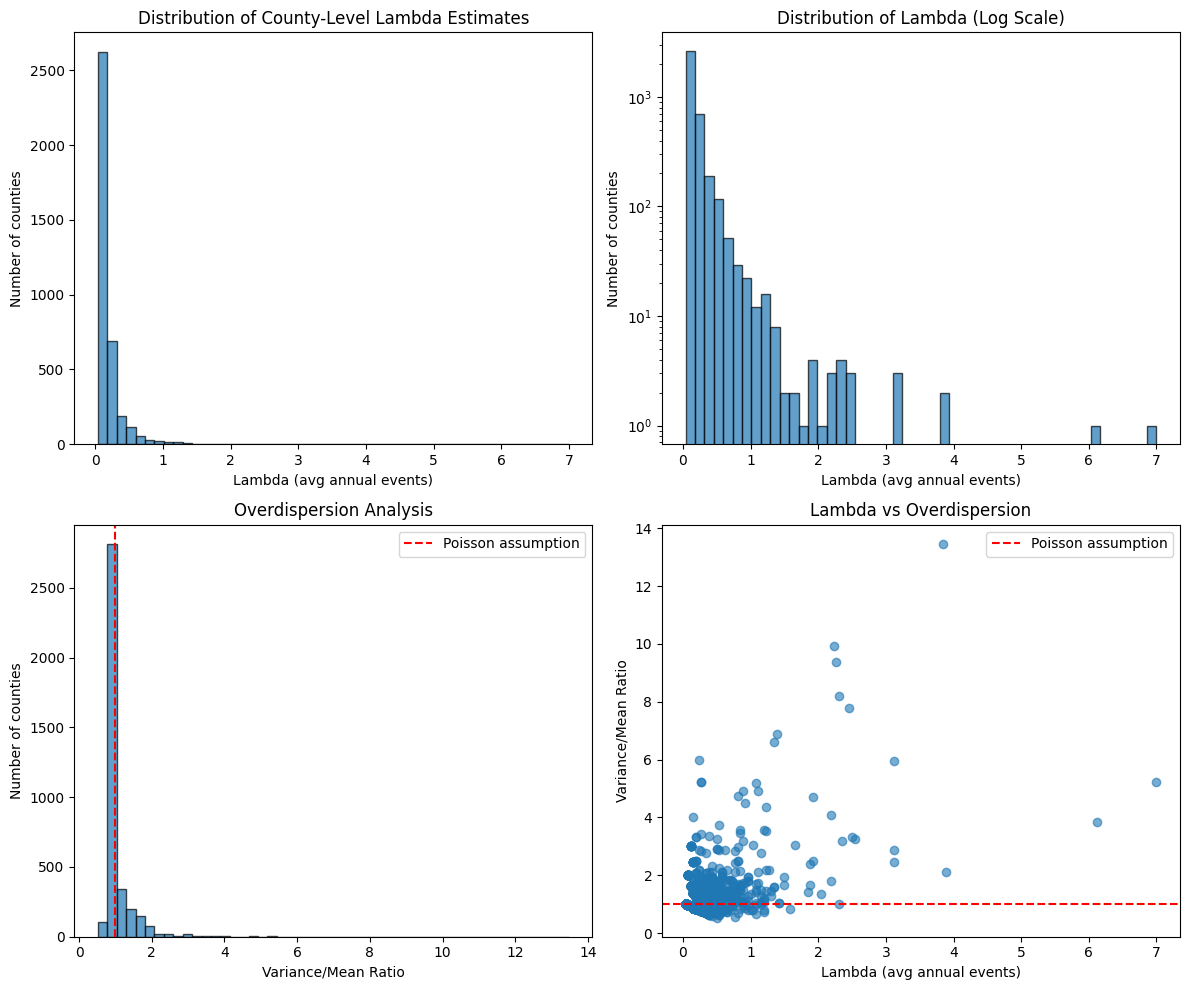

In [14]:
# Visualize the distribution of lambda estimates
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Histogram of lambda estimates
axes[0,0].hist(county_lambdas['lambda_hat'], bins=50, alpha=0.7, edgecolor='black')
axes[0,0].set_xlabel('Lambda (avg annual events)')
axes[0,0].set_ylabel('Number of counties')
axes[0,0].set_title('Distribution of County-Level Lambda Estimates')

# Log-scale histogram for better visibility
axes[0,1].hist(county_lambdas['lambda_hat'], bins=50, alpha=0.7, edgecolor='black')
axes[0,1].set_xlabel('Lambda (avg annual events)')
axes[0,1].set_ylabel('Number of counties')
axes[0,1].set_yscale('log')
axes[0,1].set_title('Distribution of Lambda (Log Scale)')

# Overdispersion ratio
axes[1,0].hist(county_lambdas['overdispersion_ratio'], bins=50, alpha=0.7, edgecolor='black')
axes[1,0].set_xlabel('Variance/Mean Ratio')
axes[1,0].set_ylabel('Number of counties')
axes[1,0].set_title('Overdispersion Analysis')
axes[1,0].axvline(x=1, color='red', linestyle='--', label='Poisson assumption')
axes[1,0].legend()

# Scatter: lambda vs overdispersion
axes[1,1].scatter(county_lambdas['lambda_hat'], county_lambdas['overdispersion_ratio'], alpha=0.6)
axes[1,1].set_xlabel('Lambda (avg annual events)')
axes[1,1].set_ylabel('Variance/Mean Ratio')
axes[1,1].set_title('Lambda vs Overdispersion')
axes[1,1].axhline(y=1, color='red', linestyle='--', label='Poisson assumption')
axes[1,1].legend()

plt.tight_layout()
plt.show()

In [15]:
# Summary statistics for lambda estimates
print("Summary of lambda estimates across all counties:")
print(county_lambdas['lambda_hat'].describe())

print(f"\nData completeness:")
print(f"Total counties: {len(county_lambdas)}")
print(f"Counties with ≥10 years data: {(county_lambdas['years_observed'] >= 10).sum()}")
print(f"Counties with ≥20 years data: {(county_lambdas['years_observed'] >= 20).sum()}")
print(f"Mean years observed: {county_lambdas['years_observed'].mean():.1f}")

Summary of lambda estimates across all counties:
count    3788.000000
mean        0.182576
std         0.297967
min         0.038500
25%         0.038500
50%         0.115400
75%         0.192300
max         7.000000
Name: lambda_hat, dtype: float64

Data completeness:
Total counties: 3788
Counties with ≥10 years data: 3788
Counties with ≥20 years data: 3788
Mean years observed: 26.0


In [16]:
# Create final Poisson risk parameters table for modeling
poisson_risk_params = county_lambdas[['county_fips', 'lambda_hat', 'years_observed', 'total_events']].copy()

# Add confidence intervals for lambda estimates (assuming Poisson MLE)
# For Poisson MLE, CI is approximately: λ ± 1.96 * sqrt(λ/n)
poisson_risk_params['lambda_se'] = np.sqrt(poisson_risk_params['lambda_hat'] / poisson_risk_params['years_observed'])
poisson_risk_params['lambda_ci_lower'] = poisson_risk_params['lambda_hat'] - 1.96 * poisson_risk_params['lambda_se']
poisson_risk_params['lambda_ci_upper'] = poisson_risk_params['lambda_hat'] + 1.96 * poisson_risk_params['lambda_se']

# Ensure lower bound is non-negative
poisson_risk_params['lambda_ci_lower'] = np.maximum(0, poisson_risk_params['lambda_ci_lower'])

print("Poisson Risk Parameters (sample):")
display(poisson_risk_params.head(10))

Poisson Risk Parameters (sample):


,county_fips,lambda_hat,years_observed,total_events,lambda_se,lambda_ci_lower,lambda_ci_upper
0,01001,0.5000,26,13,0.138675,0.228197,0.771803
1,01002,0.1538,26,4,0.076912,0.003053,0.304547
2,01003,1.1538,26,30,0.210658,0.740910,1.566690
3,01004,0.0769,26,2,0.054385,0.000000,0.183494
4,01005,0.2308,26,6,0.094217,0.046134,0.415466
5,01006,0.4231,26,11,0.127566,0.173071,0.673129
6,01007,0.3846,26,10,0.121624,0.146218,0.622982
7,01008,0.1538,26,4,0.076912,0.003053,0.304547
8,01009,0.4231,26,11,0.127566,0.173071,0.673129
9,01010,0.0385,26,1,0.038481,0.000000,0.113922


In [17]:
# Risk classification based on lambda estimates
def classify_risk_level(lambda_val):
    if lambda_val < 0.5:
        return 'Very Low'
    elif lambda_val < 2:
        return 'Low' 
    elif lambda_val < 5:
        return 'Moderate'
    elif lambda_val < 10:
        return 'High'
    else:
        return 'Very High'

poisson_risk_params['risk_category'] = poisson_risk_params['lambda_hat'].apply(classify_risk_level)

print("Risk category distribution:")
print(poisson_risk_params['risk_category'].value_counts().sort_index())

Risk category distribution:
risk_category
High           2
Low          235
Moderate      16
Very Low    3535
Name: count, dtype: int64


In [18]:
# Save the Poisson parameters to database for use in compound model
dbt.load_data(poisson_risk_params, "POISSON_FREQUENCY_PARAMS", if_exists="replace")
print("Poisson frequency parameters saved to database as POISSON_FREQUENCY_PARAMS")


Created SQLAlchemy engine for disaster_db
Data loaded successfully into POISSON_FREQUENCY_PARAMS
Poisson frequency parameters saved to database as POISSON_FREQUENCY_PARAMS


In [19]:
# Check what NRI tables are available
nri_tables = dbt.query("""
    SELECT table_name 
    FROM information_schema.tables 
    WHERE table_schema='public' 
    AND table_name LIKE '%nri%'
""")
print("Available NRI tables:")
display(nri_tables)

Created SQLAlchemy engine for disaster_db


Error executing query: sqlalchemy.cyextension.immutabledict.immutabledict is not a sequence
Available NRI tables:


""


In [20]:
# Check if we can use census_resilience table for county mapping (it should have FIPS)
try:
    census_fips_check = dbt.query("""
        SELECT column_name 
        FROM information_schema.columns 
        WHERE table_name='census_resilience'
        AND (column_name LIKE '%fips%' OR column_name LIKE '%geoid%')
    """)
    print("\nFIPS/GEOID columns in census_resilience:")
    display(census_fips_check)
    
    # Sample the data to see FIPS format
    census_sample = dbt.query("SELECT * FROM census_resilience LIMIT 5")
    print("\nSample census_resilience data:")
    display(census_sample.head())
    
except Exception as e:
    print(f"Error checking census_resilience: {e}")

Created SQLAlchemy engine for disaster_db
Error executing query: sqlalchemy.cyextension.immutabledict.immutabledict is not a sequence

FIPS/GEOID columns in census_resilience:


""


Created SQLAlchemy engine for disaster_db

Sample census_resilience data:


,POPUNI,PRED0_E,PRED0_M,PRED0_PE,PRED0_PM,PRED12_E,PRED12_M,PRED12_PE,PRED12_PM,PRED3_E,PRED3_M,PRED3_PE,PRED3_PM,FIPS,COUNTY_FIPS,VULNERABILITY_RATE,RESILIENCE_RATE,VULNERABILITY_SCORE,POPULATION
0,1815,560,228,30.85,12.56,871,239,47.99,13.17,384,205,21.16,11.29,01001020100,01001,21.16,30.85,1.35465,1815
1,2004,720,262,35.93,13.07,896,269,44.71,13.42,388,222,19.36,11.08,01001020200,01001,19.36,35.93,1.25145,2004
2,3313,817,404,24.66,12.19,1831,405,55.27,12.22,665,317,20.07,9.57,01001020300,01001,20.07,24.66,1.43115,3313
3,4343,1301,522,29.96,12.02,2274,523,52.36,12.04,768,407,17.68,9.37,01001020400,01001,17.68,29.96,1.31580,4343
4,4442,1979,515,44.55,11.59,1670,515,37.60,11.59,793,392,17.85,8.82,01001020501,01001,17.85,44.55,1.09950,4442


In [21]:
# Create state-level risk mapping without geographic boundaries
# Extract state FIPS from county FIPS (first 2 digits)
poisson_risk_params['state_fips'] = poisson_risk_params['county_fips'].str[:2]

# State FIPS to state name mapping (major states)
state_fips_map = {
    '01': 'Alabama', '02': 'Alaska', '04': 'Arizona', '05': 'Arkansas', '06': 'California',
    '08': 'Colorado', '09': 'Connecticut', '10': 'Delaware', '11': 'DC', '12': 'Florida',
    '13': 'Georgia', '15': 'Hawaii', '16': 'Idaho', '17': 'Illinois', '18': 'Indiana',
    '19': 'Iowa', '20': 'Kansas', '21': 'Kentucky', '22': 'Louisiana', '23': 'Maine',
    '24': 'Maryland', '25': 'Massachusetts', '26': 'Michigan', '27': 'Minnesota', '28': 'Mississippi',
    '29': 'Missouri', '30': 'Montana', '31': 'Nebraska', '32': 'Nevada', '33': 'New Hampshire',
    '34': 'New Jersey', '35': 'New Mexico', '36': 'New York', '37': 'North Carolina', '38': 'North Dakota',
    '39': 'Ohio', '40': 'Oklahoma', '41': 'Oregon', '42': 'Pennsylvania', '44': 'Rhode Island',
    '45': 'South Carolina', '46': 'South Dakota', '47': 'Tennessee', '48': 'Texas', '49': 'Utah',
    '50': 'Vermont', '51': 'Virginia', '53': 'Washington', '54': 'West Virginia', '55': 'Wisconsin', '56': 'Wyoming'
}

poisson_risk_params['state_name'] = poisson_risk_params['state_fips'].map(state_fips_map)

In [22]:
# Aggregate risk statistics by state
state_risk_summary = poisson_risk_params.groupby(['state_fips', 'state_name']).agg({
    'lambda_hat': ['count', 'mean', 'median', 'max', 'std'],
    'total_events': 'sum',
    'risk_category': lambda x: x.value_counts().to_dict()
}).round(3)

# Flatten column names
state_risk_summary.columns = ['_'.join(col).strip() for col in state_risk_summary.columns]
state_risk_summary = state_risk_summary.reset_index()

# Rename for clarity
state_risk_summary.rename(columns={
    'lambda_hat_count': 'counties_count',
    'lambda_hat_mean': 'avg_lambda',
    'lambda_hat_median': 'median_lambda', 
    'lambda_hat_max': 'max_lambda',
    'lambda_hat_std': 'lambda_std',
    'total_events_sum': 'state_total_events'
}, inplace=True)

print("State-level disaster risk summary:")
display(state_risk_summary.sort_values('avg_lambda', ascending=False).head(15))

State-level disaster risk summary:


,state_fips,state_name,counties_count,avg_lambda,median_lambda,max_lambda,lambda_std,state_total_events,risk_category_<lambda>
8,11,DC,1,0.962,0.962,0.962,NaN,25,{'Low': 1}
7,10,Delaware,5,0.631,0.577,0.962,0.286,82,"{'Low': 4, 'Very Low': 1}"
2,04,Arizona,59,0.524,0.154,3.846,0.750,804,"{'Very Low': 40, 'Low': 15, 'Moderate': 4}"
28,32,Nevada,21,0.496,0.077,7.000,1.511,271,"{'Very Low': 19, 'Low': 1, 'High': 1}"
9,12,Florida,117,0.458,0.231,3.115,0.582,1392,"{'Very Low': 87, 'Low': 25, 'Moderate': 5}"
30,34,New Jersey,40,0.403,0.308,1.154,0.304,419,"{'Very Low': 28, 'Low': 12}"
4,06,California,123,0.326,0.154,3.115,0.464,1042,"{'Very Low': 97, 'Low': 24, 'Moderate': 2}"
6,09,Connecticut,13,0.281,0.192,0.962,0.269,95,"{'Very Low': 11, 'Low': 2}"
0,01,Alabama,95,0.262,0.192,1.308,0.250,647,"{'Very Low': 81, 'Low': 14}"
20,24,Maryland,37,0.257,0.154,1.154,0.270,247,"{'Very Low': 32, 'Low': 5}"
